In [1]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from typing import Optional
from scipy.stats import gaussian_kde

In [2]:
# Constants
min_data_points = 10
file = "../data/SSCURVES(1-61).xlsx"


Excluding sheet 35, because it has less than 10 datapoints
Excluding sheet 36, because it has less than 10 datapoints
Excluding sheet 38, because it has less than 10 datapoints
Excluding sheet 39, because it has less than 10 datapoints
Excluding sheet 40, because it has less than 10 datapoints
Excluding sheet 42, because it has less than 10 datapoints
Excluding sheet 43, because it has less than 10 datapoints
Excluding sheet 44, because it has less than 10 datapoints


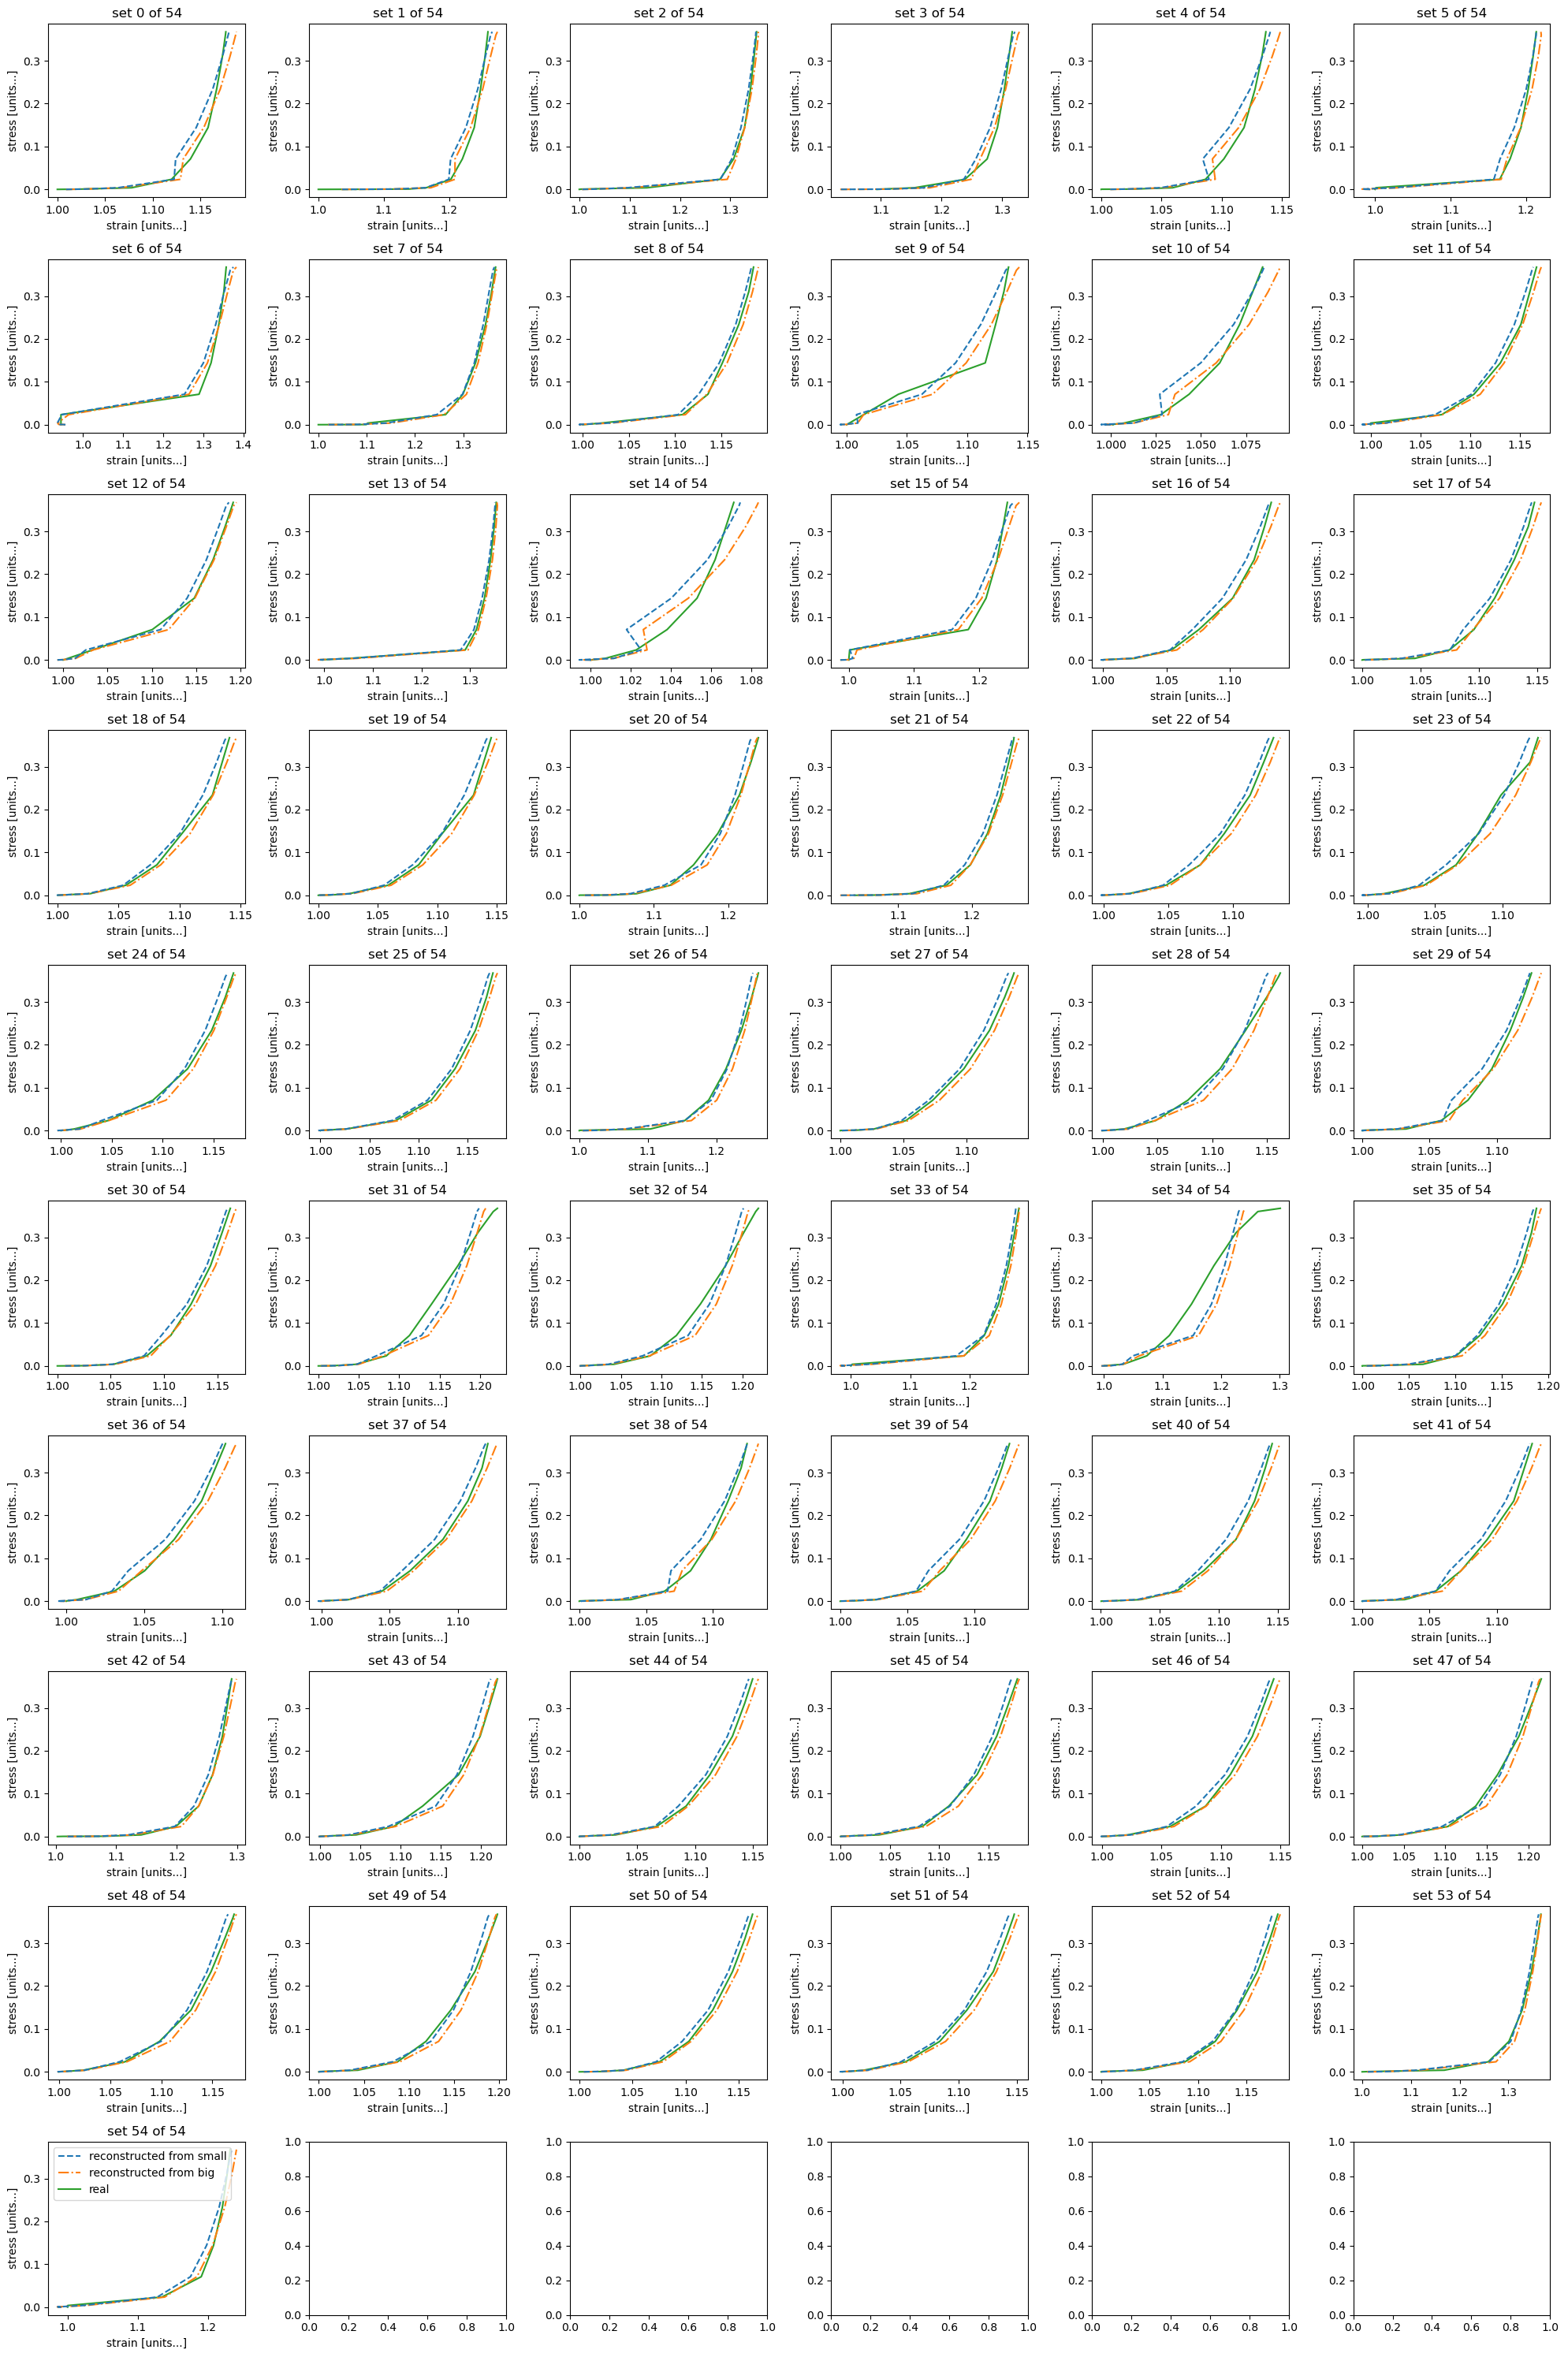

In [3]:
xls = pd.ExcelFile(file)

# Calculate smallest stress range.
# and make list of dataframes
smallest_stress_range = np.inf
df_list = []
for sheet in xls.sheet_names:
    df = pd.read_excel(file, sheet_name=sheet)
    df = df.dropna(subset=['Strain', 'Stress'])

    # Exclude bad measurements.
    if len(df) < min_data_points:
        print(f"Excluding sheet {sheet}, because it has less than {min_data_points} datapoints")
        continue

    low_stress = df['Stress'].min()
    high_stress = df['Stress'].max()
    stress_range = high_stress - low_stress
    if stress_range < smallest_stress_range:
        smallest_stress_range = stress_range
        idx_smallest_stress_range = len(df_list)
    
    df_list.append(df)

# Make data matrix
X = []
for df in df_list:

    x = np.interp(df_list[idx_smallest_stress_range]['Stress'], df['Stress'], df['Strain'])
    
    X.append(x)

X = np.array(X)

# Do PCA
pca_big = PCA(n_components=3).fit(X)
components_big = pca_big.components_
scores_big = pca_big.explained_variance_
mean_big = pca_big.mean_

# percent = 60
# slice_at = int(X.shape[0] * percent / 100)

pca_small = PCA(n_components=3).fit(X[:53])
components_small = pca_small.components_
scores_small = pca_small.explained_variance_
mean_small = pca_small.mean_

# transformed_X = pca.transform(X[2].reshape(-1, df_list[idx_smallest_stress_range]['Strain'].shape[0])).flatten()
transformed_X_from_big = pca_big.transform(X)
reconstructed_x_from_small = pca_small.inverse_transform(transformed_X_from_big)

transformed_X_from_small = pca_small.transform(X)
reconstructed_x_from_big = pca_big.inverse_transform(transformed_X_from_small)

fig, axs = plt.subplots(10, 6, figsize=(20, 30))

for i, (data, ax) in enumerate(zip(X, axs.flat)):
    ax.plot(reconstructed_x_from_small[i], df_list[idx_smallest_stress_range]['Stress'], '--', label='reconstructed from small', zorder=3)
    ax.plot(reconstructed_x_from_big[i], df_list[idx_smallest_stress_range]['Stress'], '-.', label='reconstructed from big', zorder=2)
    ax.plot(data, df_list[idx_smallest_stress_range]['Stress'], '-', label='real', zorder=1)
    ax.set_xlabel('strain [units...]')
    ax.set_ylabel('stress [units...]')
    ax.set_title(f'set {i} of {X.shape[0] - 1}')

ax.legend()
plt.tight_layout()
plt.show()

In [4]:
def calculate_smallest_range(stop: Optional[int] = None):
    """
    Returns:
        [range, idx, number of points]
    """
    smallest_stress_range = [np.inf, None, None] # [range, idx, number of points]
    for sheet in xls.sheet_names:
        df = pd.read_excel(file, sheet_name=sheet)
        df = df.dropna(subset=['Strain', 'Stress'])

        # TODO: Some data MUST be excluded, right? There are dataseries with less than 10 points.
        # I don't believe those could be good...
        min_data_points = 15
        if len(df) < min_data_points:
            print(f"Excluding sheet {sheet}, because it has less than {min_data_points} datapoints")
            continue
        low = df['Stress'].min()
        high = df['Stress'].max()
        stress_range = high - low
        if stress_range < smallest_stress_range[0]:
            smallest_stress_range = [stress_range, sheet, len(df)]

    print(f"Case {smallest_stress_range[1]} has the shortest stress range of {smallest_stress_range[0]} with {smallest_stress_range[2]} points.")

    return smallest_stress_range

In [5]:
def make_data_matrix(smallest_stress_range: list[float, int, int], stop: Optional[int] = None):    
    df_list = []
    for sheet in xls.sheet_names:
        df = pd.read_excel(file, sheet_name=sheet)
        df = df.dropna(subset=['Strain', 'Stress'])

        min_data_points = 15
        if len(df) < min_data_points:
            continue

        if stop and len(df_list) == stop:
            print(f"Stopping at {sheet}.")
            break
        df_list.append(df)

    y_dflist = []
    xc = int(smallest_stress_range[1]) - 1

    for i in range(len(df_list)):
        interpolated = np.interp(df_list[xc]['Stress'], df_list[i]['Stress'], df_list[i]['Strain'])
        y_dflist.append(interpolated)
    
    print(f"Total included curves: {len(y_dflist)}")

    X = np.array(y_dflist)

    return X, df_list[xc]['Stress'], df_list[xc]['Strain']

In [6]:
def calculate_components(X, number):
    pca = PCA(n_components=number).fit(X)
    components = pca.components_
    scores = pca.explained_variance_
    mean = pca.mean_

    return components, scores, mean, pca

In [7]:
def plot_spread_of_set(stop: Optional[int] = None):
    smallest_stress_range = calculate_smallest_range(stop)
    X, base, base2 = make_data_matrix(smallest_stress_range, stop)

    components, scores, mean, pca = calculate_components(X, 3)

    variances = []
    distances_array = []
    for i, mean_i in enumerate(mean):
        distances = np.abs(mean_i - X[i])
        distances_array.append(distances)
        var = np.var(distances)
        variances.append(var)

    fig, axs = plt.subplots(3, 6, figsize=(20, 10))

    axs[0][0].set_xlabel('i')
    axs[0][0].set_ylabel('variance')
    axs[0][0].plot(variances)
    axs[0][0].set_ylim([0, 0.018])

    for dist, ax in zip(distances_array, axs.flat[1:]):
        dist = np.sort(dist)
        kde = gaussian_kde(dist)
        density = kde(dist)
        ax.hist(dist, bins=X.shape[1])

        ax.plot(dist, density)
        ax.set_xlabel('distance')
        ax.set_ylabel('count')
        ax.set_ylim([0, 10])

    plt.tight_layout()

    plt.show(block=False)

    return components, scores, mean, base, pca, X, base2


    

Excluding sheet 35, because it has less than 15 datapoints
Excluding sheet 36, because it has less than 15 datapoints
Excluding sheet 37, because it has less than 15 datapoints
Excluding sheet 38, because it has less than 15 datapoints
Excluding sheet 39, because it has less than 15 datapoints
Excluding sheet 40, because it has less than 15 datapoints
Excluding sheet 41, because it has less than 15 datapoints
Excluding sheet 42, because it has less than 15 datapoints
Excluding sheet 43, because it has less than 15 datapoints
Excluding sheet 44, because it has less than 15 datapoints
Case 32 has the shortest stress range of 0.39937500000000004 with 44 points.
Total included curves: 53


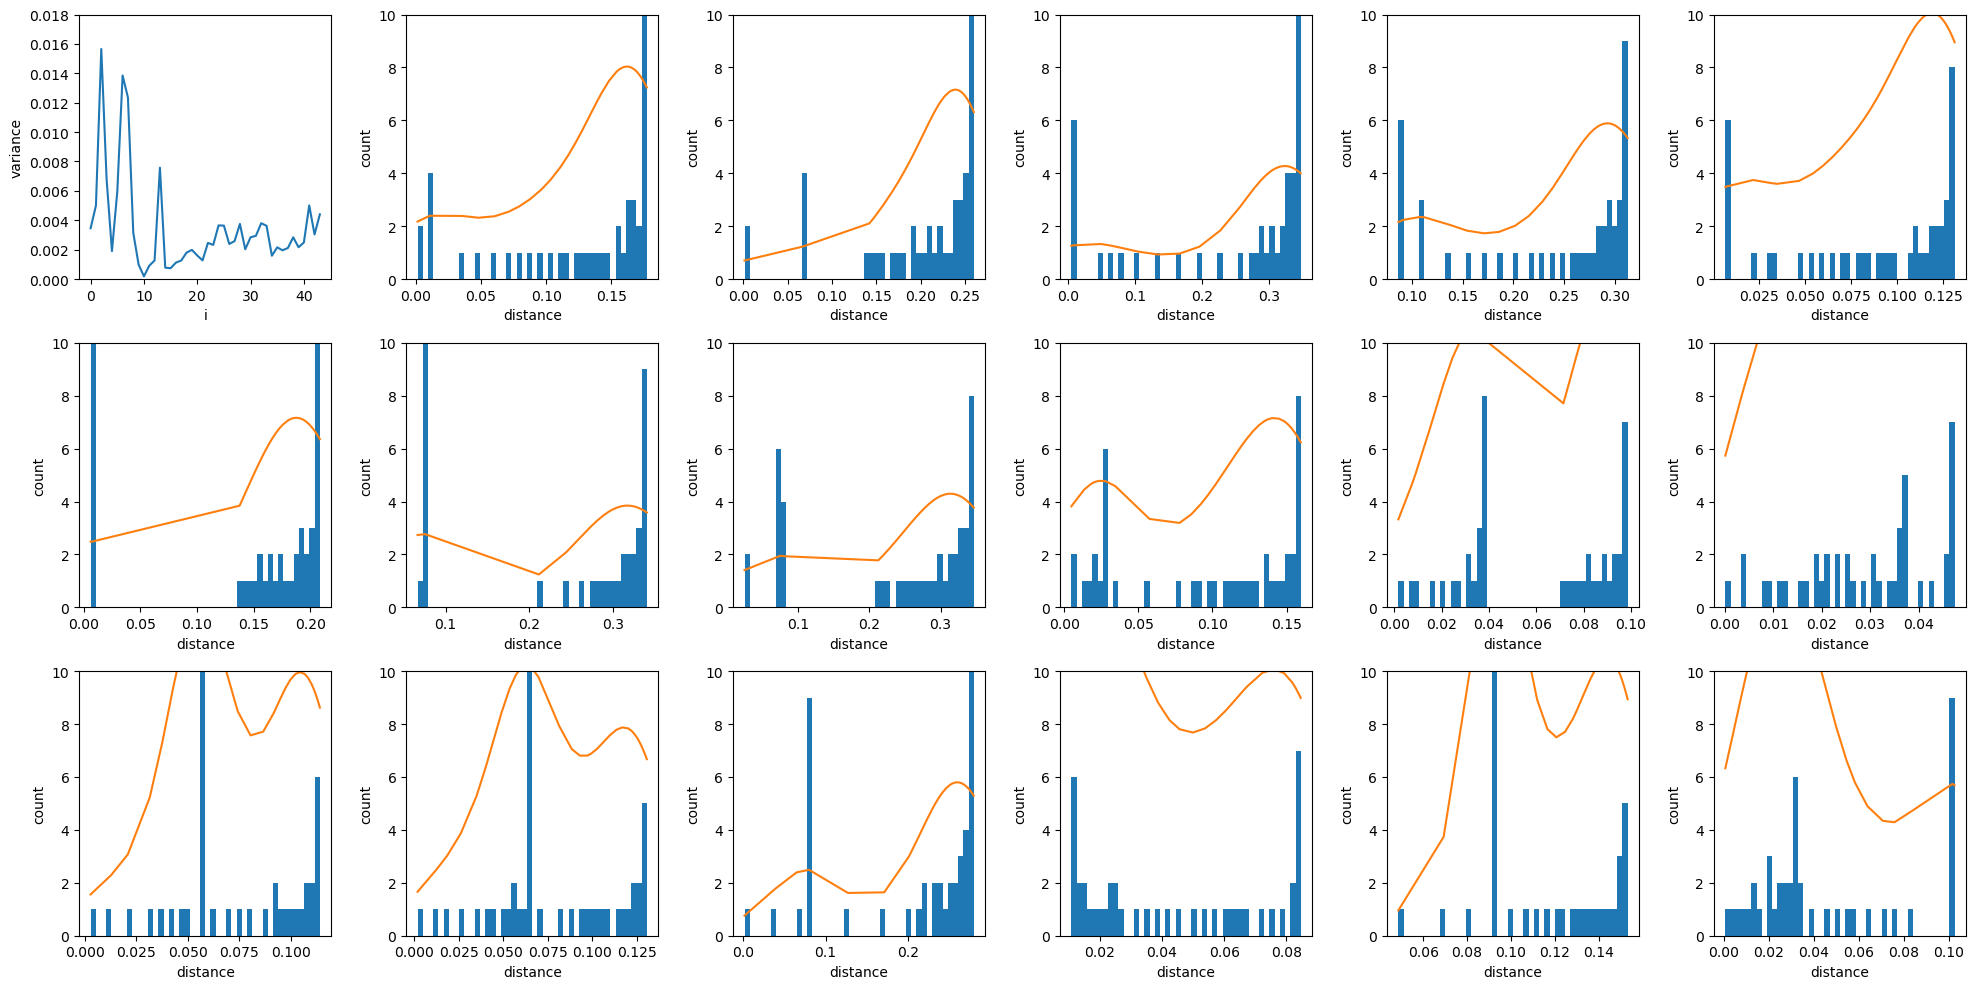

In [8]:
components_large, scores_large, mean_large, base, pca_large, X, base2 = plot_spread_of_set()

Excluding sheet 35, because it has less than 15 datapoints
Excluding sheet 36, because it has less than 15 datapoints
Excluding sheet 37, because it has less than 15 datapoints
Excluding sheet 38, because it has less than 15 datapoints
Excluding sheet 39, because it has less than 15 datapoints
Excluding sheet 40, because it has less than 15 datapoints
Excluding sheet 41, because it has less than 15 datapoints
Excluding sheet 42, because it has less than 15 datapoints
Excluding sheet 43, because it has less than 15 datapoints
Excluding sheet 44, because it has less than 15 datapoints
Case 32 has the shortest stress range of 0.39937500000000004 with 44 points.
Stopping at 61.
Total included curves: 50


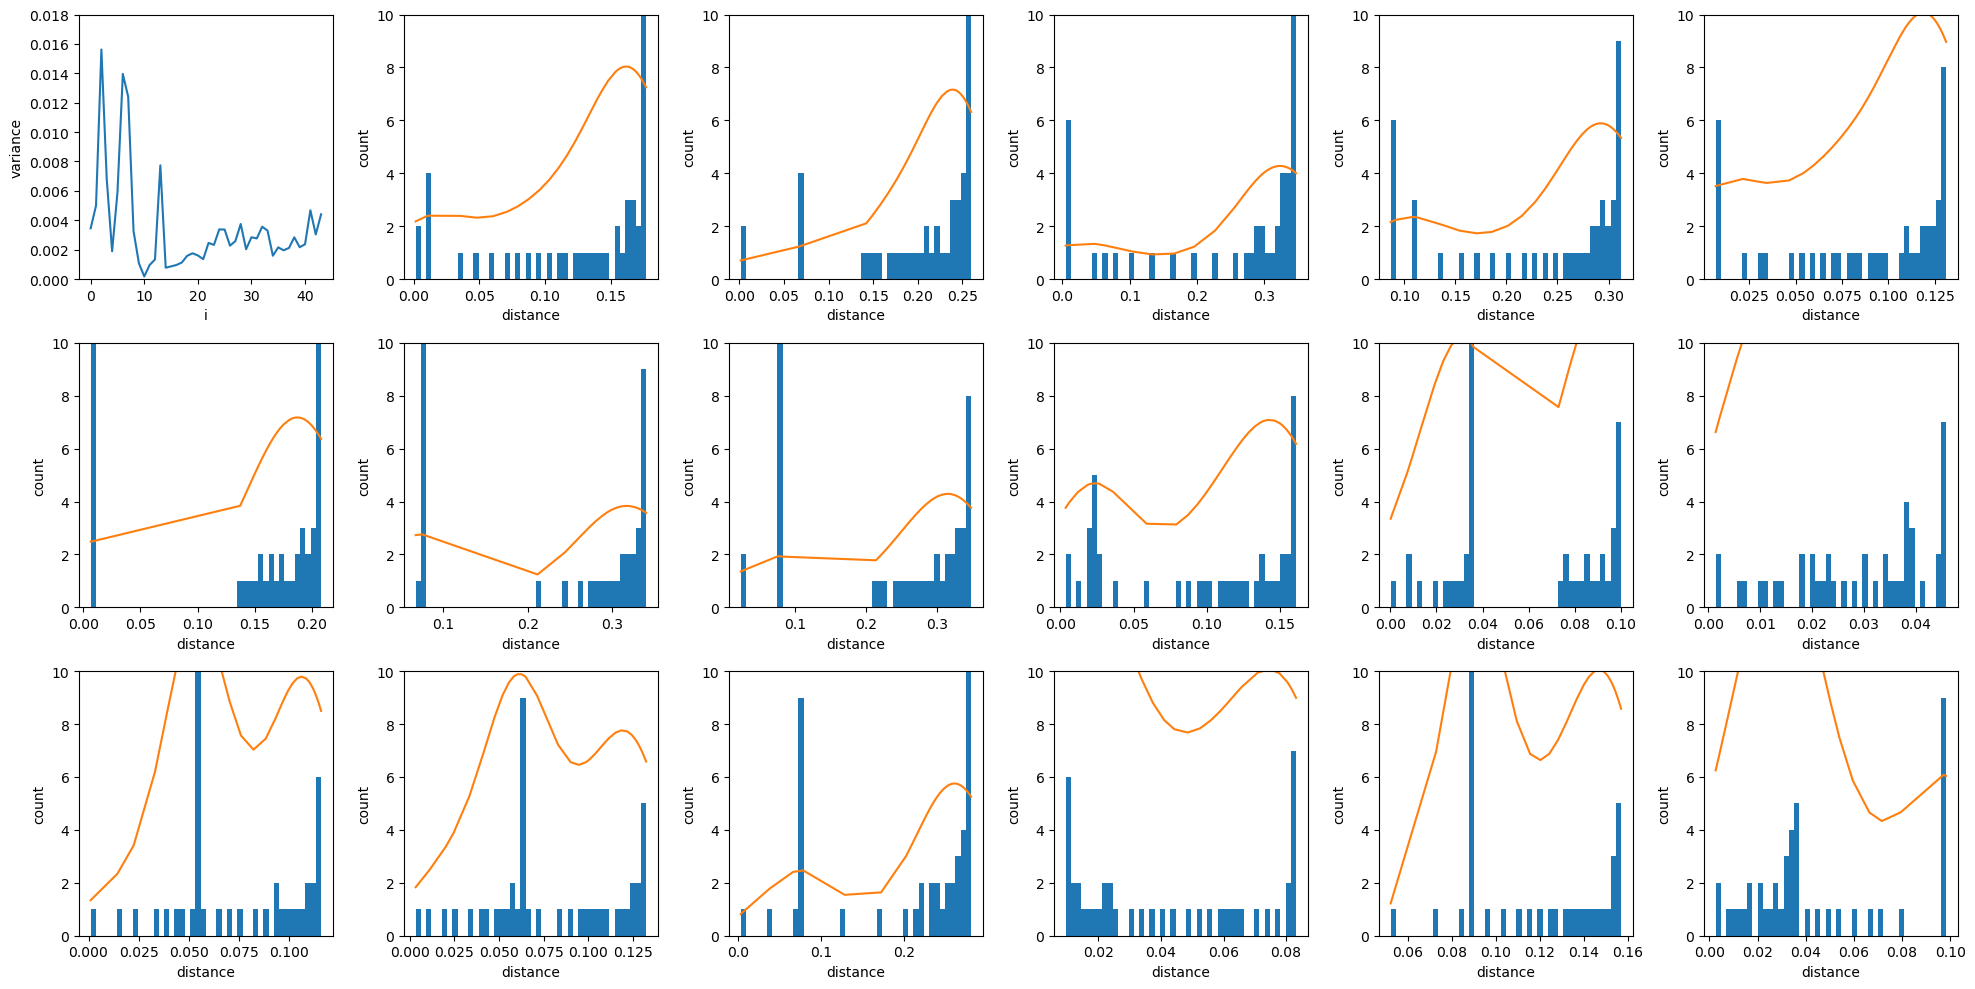

In [9]:
components_small, scores_small, mean_small, base, pca_small, X, base2 = plot_spread_of_set(stop=50) # 35 ~ 60% of all data.

In [10]:
# Mixing components!
fitted_scores_using_large = pca_large.transform(X).flatten()
fitted_scores_using_small = pca_small.transform(X).flatten()

reconstructed_l_l = pca_large.inverse_transform(fitted_scores_using_large)
reconstructed_s_l = pca_small.inverse_transform(fitted_scores_using_large)
reconstructed_l_s = pca_large.inverse_transform(fitted_scores_using_small)
reconstructed_s_s = pca_small.inverse_transform(fitted_scores_using_small)

plt.plot(reconstructed_l_l, base, label='l-scores, l-comps')
plt.plot(reconstructed_s_l, base, label='l-scores, s-comps')
plt.plot(reconstructed_l_s, base, label='s-scores, l-comps')
plt.plot(reconstructed_s_s, base, label='s-scores, s-comps')
plt.plot(base2, base, label='measurement')

plt.legend()


ValueError: shapes (150,) and (3,44) not aligned: 150 (dim 0) != 3 (dim 0)